In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras._tf_keras.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [21]:
#setting
tflite_model_name = 'nhung_model'  # Will be given .tflite suffix
c_model_name = 'nhung_model'

In [13]:
# Load the data
data = pd.read_csv('C://Users//84946//OneDrive//Desktop//Documents PTIT//HK2_nam4//Lap_trinh_nhung//project//Data//soil_moisture_data.csv')


In [14]:
# Convert the 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'])

# Sort data by time to ensure proper sequencing
data = data.sort_values(by='Time')

# Ensure all data is numeric and handle missing values
data = data.apply(pd.to_numeric, errors='coerce')
data = data.dropna()

# Normalize the data
scaler = StandardScaler()
data[['SoilMoisture', 'Temperature', 'Humidity']] = scaler.fit_transform(data[['SoilMoisture', 'Temperature', 'Humidity']])


In [15]:
# Function to create time series sequences
def create_sequences(data, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:i + time_steps][['SoilMoisture', 'Temperature', 'Humidity']].values)
        y.append(data.iloc[i + time_steps][['SoilMoisture', 'Temperature', 'Humidity']].values)
    return np.array(X), np.array(y)


In [16]:
# Define time steps (how many past timestamps to use)
time_steps = 3
X, y = create_sequences(data, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM Model
model = tf.keras.Sequential([
    layers.Input(shape=(time_steps, 3)),
    layers.LSTM(64, activation='relu', return_sequences=True),
    layers.LSTM(32, activation='relu'),
    layers.Dense(3)  # Output: SoilMoisture, Temperature, Humidity
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.0020 - mae: 0.8717 - val_loss: 0.9115 - val_mae: 0.8182
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9709 - mae: 0.8561 - val_loss: 0.9116 - val_mae: 0.8183
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0223 - mae: 0.8846 - val_loss: 0.9122 - val_mae: 0.8184
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0448 - mae: 0.8958 - val_loss: 0.9125 - val_mae: 0.8184
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0037 - mae: 0.8763 - val_loss: 0.9133 - val_mae: 0.8184
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9963 - mae: 0.8678 - val_loss: 0.9136 - val_mae: 0.8183
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0203 - mae: 0.8836 - val_loss: 0.9135 - val_mae: 0.8184
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0282 - mae: 0.8843 - val_loss: 0.9138 - val_mae: 0.8183
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0

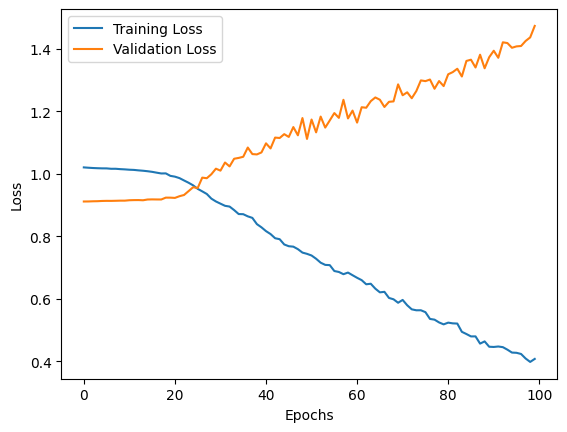

In [18]:
# Plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


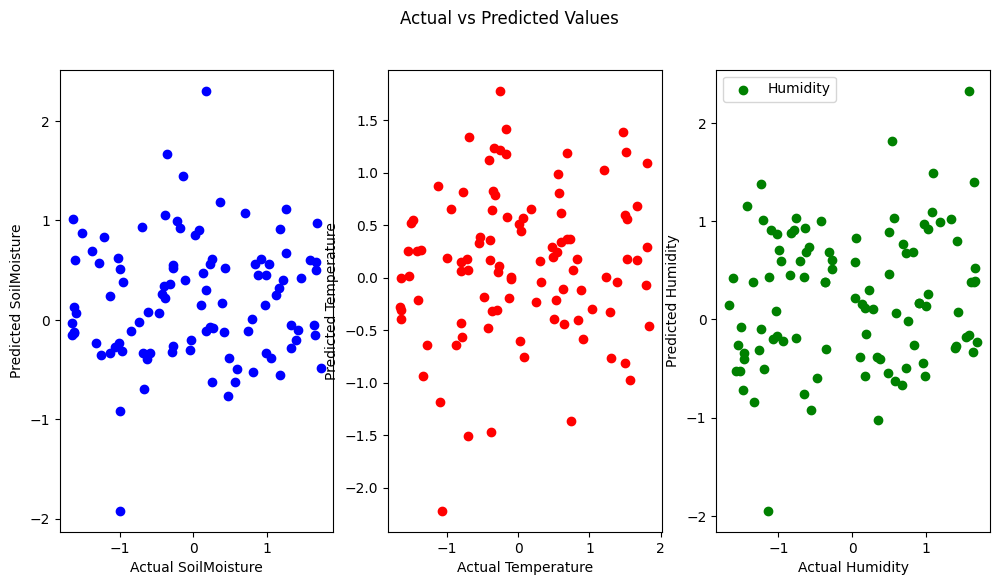

In [19]:
# Make predictions
predictions = model.predict(X_test)

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(y_test[:, 0], predictions[:, 0], label='SoilMoisture', color='blue')
plt.xlabel('Actual SoilMoisture')
plt.ylabel('Predicted SoilMoisture')

plt.subplot(1, 3, 2)
plt.scatter(y_test[:, 1], predictions[:, 1], label='Temperature', color='red')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')

plt.subplot(1, 3, 3)
plt.scatter(y_test[:, 2], predictions[:, 2], label='Humidity', color='green')
plt.xlabel('Actual Humidity')
plt.ylabel('Predicted Humidity')

plt.suptitle('Actual vs Predicted Values')
plt.legend()
plt.show()

In [34]:
# Convert LSTM model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable select TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model
tflite_model_name = 'nhung_model'
with open(tflite_model_name + '.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\84946\AppData\Local\Temp\tmp2qf3h6vu\assets


INFO:tensorflow:Assets written to: C:\Users\84946\AppData\Local\Temp\tmp2qf3h6vu\assets


Saved artifact at 'C:\Users\84946\AppData\Local\Temp\tmp2qf3h6vu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 3), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  3040880710032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3040880713104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3040880713680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3040880713872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3040880714832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3040880715408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3040880714448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  3040880715792: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [36]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [37]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))